In [1]:
!pip install livelossplot

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
from tensorflow.keras.layers import Normalization
import pickle
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale
from livelossplot import PlotLossesKerasTF
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
tfd = tfp.distributions
import tensorflow as tf
import matplotlib.pyplot as plt

Read in Data and filter to keep only samples with at least thow spectra readings

In [4]:
kiwi = pd.read_csv('/data//kiwifruit_dat.csv')
kiwi = kiwi.dropna(subset=['SSC'])
kiwi = kiwi[kiwi['DM'] > 7]
kiwi['Date'] = pd.to_datetime(kiwi['Date'], format='%d/%m/%Y')
kiwi = kiwi.sort_values(
    by=['Date'],  # Specify the sorting columns
    kind='stable'                  # Ensure stability for 'sample_id' order
)

# Group by 'sample_id' and filter for groups with size >= 2
kiwi_filtered = kiwi.groupby('sample_id').filter(lambda x: len(x) >= 2)

# Display the first few rows of the filtered DataFrame
display(kiwi_filtered.head())

# Display the number of unique sample_ids before and after filtering
print(f"Number of unique sample_ids before filtering: {kiwi['sample_id'].nunique()}")
print(f"Number of unique sample_ids after filtering: {kiwi_filtered['sample_id'].nunique()}")

,Dataset,Date,device,sample_id,SSC,DM,X402,X405,X408,X411,...,X1110,X1113,X1116,X1119,X1122,X1125,X1128,X1131,X1134,X1137
0,Training,2017-03-28,KK1,1,10.2,15.7,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Training,2017-03-28,KK2,1,10.2,15.7,0.0,0.0,0.0,1.036350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Training,2017-03-28,TP1,1,10.2,15.7,0.0,0.0,0.0,0.752586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Training,2017-03-28,TP2,1,10.2,15.7,0.0,0.0,0.0,1.138167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Training,2017-03-28,TP3,1,10.2,15.7,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of unique sample_ids before filtering: 5416
Number of unique sample_ids after filtering: 4316


In [5]:
kiwi = kiwi_filtered

In [6]:
features = kiwi.loc[:,'X402':'X1065']

features_train_norm=(features-features.loc[kiwi['Dataset'] == 'Training',:].mean())/features.loc[kiwi ['Dataset'] == 'Training',:].std()


In [7]:
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
deriv=2
polyo=2
width=13

X_train_norm_sg = savgol_filter(features_train_norm, width, polyorder = polyo,deriv=deriv)


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA object
pca = PCA()

# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_train_norm_sg))

{'whiskers': [<matplotlib.lines.Line2D at 0x7e22ab6ffad0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e22ab72c2f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e22abcdc9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e22ab72e0f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e22ab72e420>],
 'means': []}

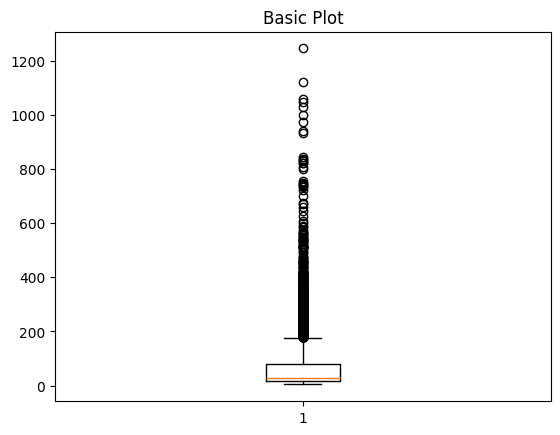

In [9]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet
robust_cov  = MinCovDet().fit(T[:,:20])

# Get the Mahalanobis distance
m  = robust_cov.mahalanobis(T[:,:20])

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(m[m<1500])

{'whiskers': [<matplotlib.lines.Line2D at 0x7e22ab6112b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e22ab611880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e22ab610ec0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e22ab611ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e22ab612270>],
 'means': []}

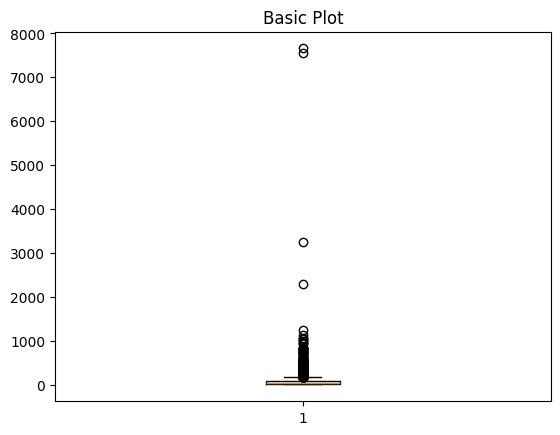

In [10]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(m[m<10000])

In [11]:
kiwi=kiwi[m<1200]

In [12]:
kiwi_sorted = kiwi.sort_values(by=['sample_id'])


In [13]:
repeated_kiwi = kiwi_sorted.loc[kiwi_sorted.index.repeat(kiwi_sorted.groupby(['sample_id']).transform('size'))]


In [14]:
# Assuming your dataframe is called 'kiwi'
if kiwi['SSC'].isnull().any():
    print("SSC column has NaN values.")
else:
    print("SSC column does not have NaN values.")

SSC column does not have NaN values.


In [15]:
group_counts = kiwi.groupby(['sample_id']).size().to_dict()

# Step 2: Create a list to store rows for the new dataframe
repeated_rows = []

# Step 3: Iterate through each group and repeat the entire group block
for group_name, group_df in kiwi.groupby(['sample_id']):
    count = group_counts[group_name[0]]
    # Repeat the entire group block 'count' times
    for _ in range(count):
        repeated_rows.append(group_df)

# Step 4: Concatenate all the repeated blocks
repeated_kiwi_y = pd.concat(repeated_rows, ignore_index=True)

In [16]:
repeated_kiwi_x = repeated_kiwi.sort_values(
    by=['sample_id'],  # Specify the sorting columns
    kind='stable'                  # Ensure stability for 'sample_id' order
)

In [17]:
# Reset the index of both DataFrames before comparison
repeated_kiwi_x = repeated_kiwi_x.reset_index(drop=True)
repeated_kiwi_y = repeated_kiwi_y.reset_index(drop=True)
repeated_kiwi_y['device'].values

array(['KK1', 'KK2', 'TP1', ..., 'TP1', 'TP2', 'TP3'], dtype=object)

In [18]:
unique_device_date_combinations =repeated_kiwi_x[['device', 'Date']].drop_duplicates()
unique_device_date_combinations

,device,Date
0,KK1,2017-03-28
5,KK2,2017-03-28
10,TP1,2017-03-28
15,TP2,2017-03-28
20,TP3,2017-03-28
...,...,...
27695,TP3,2019-04-24
27698,TP2,2019-04-24
27701,TP1,2019-04-24
27749,KK2,2019-04-24


In [19]:
x_lower='X402'
x_upper='X1065'

In [20]:
features_x = repeated_kiwi_x.loc[:,'X402':'X1065']
features_y = repeated_kiwi_y.loc[:,'X402':'X1065']
features_x_norm=(features_x-features_x.loc[repeated_kiwi_x ['Dataset'] == 'Training',:].mean())/features_x.loc[repeated_kiwi_x ['Dataset'] == 'Training',:].std()
features_y_norm=(features_y-features_y.loc[repeated_kiwi_y['Dataset'] == 'Training',:].mean())/features_y.loc[repeated_kiwi_y['Dataset'] == 'Training',:].std()


In [21]:
def create_dataset_tail(nsamp, kiwi, x_lower='X402', x_upper='X1065', target_column='DM', BATCH_SIZE=3000):
    """
    Create a normalized dataset from kiwi training data, taking the tail by sample_id.

    Parameters:
    -----------
    nsamp : int
        Number of unique sample_ids to take from the end of the training data
    kiwi : pandas.DataFrame
        The main kiwi dataset
    x_lower : str, default 'X402'
        Lower bound column name for feature selection
    x_upper : str, default 'X1065'
        Upper bound column name for feature selection
    target_column : str, default 'DM'
        Name of the target column
    BATCH_SIZE : int, default 3000
        Batch size for the TensorFlow dataset

    Returns:
    --------
    tuple
        (dataset_label, n_repeats, features_sub_norm, labels) where:
        - dataset_label: tf.data.Dataset with batched normalized features and target labels
        - n_repeats: number of repeats needed to cover full training set
        - features_sub_norm: normalized features DataFrame
        - labels: target column values
    """
    import tensorflow as tf
    import numpy as np

    # Get training data
    kiwi_train = kiwi[kiwi['Dataset'] == 'Training']

    # Get unique sample_ids from training data and take the last nsamp
    unique_sample_ids = kiwi_train['sample_id'].unique()
    tail_sample_ids = unique_sample_ids[-nsamp:]

    # Filter data to include all observations for the selected sample_ids
    kiwi_sub = kiwi_train[kiwi_train['sample_id'].isin(tail_sample_ids)]

    # Extract features
    features_train = kiwi_train.loc[:, x_lower:x_upper]
    features_sub = kiwi_sub.loc[:, x_lower:x_upper]

    # Normalize features using training data statistics
    features_sub_norm = (features_sub - features_train.mean()) / features_train.std()

    # Create TensorFlow dataset
    dataset_label = tf.data.Dataset.from_tensor_slices((features_sub_norm, kiwi_sub[target_column]))
    dataset_label = dataset_label.batch(min(len(kiwi_sub), BATCH_SIZE))

    # Calculate number of repeats
    n_repeats = np.ceil(kiwi_train.shape[0] / BATCH_SIZE)

    return dataset_label, tail_sample_ids, features_sub_norm, kiwi_sub[target_column]

In [22]:
def create_semi_supervised_dataset(unlabeled_data, labeled_data, n_repeats,
                                 labeled_batch_size=32, unlabeled_batch_size=128):

    labeled_ds = labeled_data.shuffle(1000).repeat()
    unlabeled_ds = unlabeled_data.shuffle(1000)#.repeat()

    return tf.data.Dataset.zip((unlabeled_ds, labeled_ds ))


In [23]:
from scipy.signal import savgol_coeffs
def build_encoder(num_layers=4,conv1=1.,init_shape = 222, layer_sizes=(128,64,32,16),n_filt=50,kernel_size=13, activation ="relu",l2=0.0,preprocess=3, initializer = tf.keras.initializers.HeNormal(seed=123),last_activation = "linear"):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    encoder = keras.Sequential(name="encoder")
    encoder.add(keras.Input(init_shape))
    encoder.add(tf.keras.layers.Reshape((init_shape[0], 1), input_shape=(init_shape,)))

    if preprocess >0.0:
        sg=savgol_coeffs(13, 2, deriv=(preprocess-1), use='conv')
        encoder.add(tf.keras.layers.Conv1D(filters=1,strides=1,kernel_size=13,padding='same', activation='linear',kernel_initializer=initializer,use_bias=False))
        encoder.layers[1].set_weights(np.array([np.expand_dims(np.transpose(np.array([sg])),axis=1)]))
        encoder.layers[1].trainable = False

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    if conv1 >0.0:
        encoder.add(tf.keras.layers.Conv1D(filters=n_filt,strides=1,kernel_size=13,padding='same', activation='linear',kernel_initializer=initializer,use_bias=False))

    encoder.add(tf.keras.layers.Flatten())

    for i in range(0, num_layers):
        encoder.add(
            keras.layers.Dense(
                units=layer_sizes[i],
                activation=activation,kernel_regularizer=tf.keras.regularizers.l2(l2))
            )

    return encoder

In [24]:
class BarlowLoss(tf.keras.losses.Loss):
    """BarlowLoss class.

    BarlowLoss class. Creates a loss function based on the cross-correlation
    matrix.

    Attributes:
        batch_size: the batch size of the dataset
        lambda_amt: the value for lambda(used in cross_corr_matrix_loss)

    Methods:
        __init__: gets instance variables
        call: gets the loss based on the cross-correlation matrix
          make_diag_zeros: Used in calculating off-diagonal section
          of loss function; makes diagonals zeros.
        cross_corr_matrix_loss: creates loss based on cross correlation
          matrix.
    """

    def __init__(self, batch_size: int, lambda_amt = 1.):
        """__init__ method.

        Gets the instance variables

        Arguments:
            batch_size: An integer value representing the batch size of the
              dataset. Used for cross correlation matrix calculation.
        """

        super().__init__()
        #self.lambda_amt = 5e-3
        #self.lambda_amt = 0.01694915
        #self.lambda_amt = 0.0011
        self.lambda_amt = lambda_amt   #1.0/36.0
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        """get_off_diag method.

        Makes the diagonals of the cross correlation matrix zeros.
        This is used in the off-diagonal portion of the loss function,
        where we take the squares of the off-diagonal values and sum them.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix_loss method.

        Gets the loss based on the cross correlation matrix.
        We want the diagonals to be 1's and everything else to be
        zeros to show that the two augmented images are similar.

        Loss function procedure:
        take the diagonal of the cross-correlation matrix, subtract by 1,
        and square that value so no negatives.

        Take the off-diagonal of the cc-matrix(see get_off_diag()),
        square those values to get rid of negatives and increase the value,
        and multiply it by a lambda to weight it such that it is of equal
        value to the optimizer as the diagonal(there are more values off-diag
        then on-diag)

        Take the sum of the first and second parts and then sum them together.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)
        #c_diff = tf.math.abs(tf.linalg.diag_part(c) - 1)

        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt
        #off_diag = tf.math.abs(self.get_off_diag(c)) * self.lambda_amt

        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        """normalize method.

        Normalizes the model prediction.

        Arguments:
            output: the model prediction.

        Returns:
            Returns a normalized version of the model prediction.
        """

        return (output - tf.reduce_mean(output, axis=0)) / tf.maximum(tf.math.reduce_std(
            output, axis=0
        ),1e-8)

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix method.

        Creates a cross correlation matrix from the predictions.
        It transposes the first prediction and multiplies this with
        the second, creating a matrix with shape (n_dense_units, n_dense_units).
        See build_twin() for more info. Then it divides this with the
        batch size.

        Arguments:
            z_a_norm: A normalized version of the first prediction.
            z_b_norm: A normalized version of the second prediction.

        Returns:
            Returns a cross correlation matrix.
        """
        #return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size
        return (tf.transpose(z_a_norm) @ z_b_norm) / tf.cast(tf.shape(z_a_norm)[0], tf.float32)

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        """call method.

        Makes the cross-correlation loss. Uses the CreateCrossCorr
        class to make the cross corr matrix, then finds the loss and
        returns it(see cross_corr_matrix_loss()).

        Arguments:
            z_a: The prediction of the first set of augmented data.
            z_b: the prediction of the second set of augmented data.

        Returns:
            Returns a (rank-0) tf.Tensor that represents the loss.
        """

        #z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        #c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        c = tfp.stats.correlation(z_a, z_b, sample_axis=0, event_axis=-1)
        loss = self.cross_corr_matrix_loss(c)
        return loss

In [25]:
def get_encoder(init_shape = (222,), layer_sizes = (150,100,50), activation = "elu",last_activation = "linear",initializer = tf.keras.initializers.HeNormal(seed=123)):
    """Creates an encoder model with a variable number of dense layers.

    Args:
        layer_sizes: A tuple or list specifying the size of each dense layer.

    Returns:
        A Keras Sequential model representing the encoder.
    """

    encoder = keras.Sequential(name="encoder")
    encoder.add(keras.Input(init_shape))  # Input layer
    num_layers = len(layer_sizes)

    # Add dense layers based on layer_sizes
    for i, size in enumerate(layer_sizes):
        #encoder.add(tf.keras.layers.Dense(size, activation=activation, kernel_initializer=initializer))
        current_activation = activation if i < num_layers - 1 else last_activation
        # --- Apply UnitNorm constraint to the last layer ---
        if i == num_layers - 1:
            encoder.add(tf.keras.layers.Dense(size, activation=current_activation, kernel_initializer=initializer,
                                             kernel_constraint=tf.keras.constraints.UnitNorm(axis=0)))  # axis=0 for column-wise normalization
        else:
            encoder.add(tf.keras.layers.Dense(size, activation=current_activation, kernel_initializer=initializer))

        #encoder.add(tf.keras.layers.Dense(size, activation=current_activation, kernel_initializer=initializer))
        #encoder.add(tf.keras.layers.BatchNormalization())

    #encoder.add(tf.keras.layers.BatchNormalization())

    return encoder

In [26]:
def get_regression_head(layer_sizes = (30),reg_sizes=(1), activation = "linear",initializer = tf.keras.initializers.HeNormal(seed=123)):
    num_reg_layers = len(reg_sizes)
    regression_head= keras.Sequential(name="regression_head")
    regression_head.add(keras.Input((layer_sizes[-1],)))
    #for size in reg_sizes[0:]:
    #    regression_head.add(tf.keras.layers.Dense(size, activation=activation, kernel_initializer=initializer))
    for i, size in enumerate(reg_sizes):
        # If this is the last layer, set activation to 'linear'
        current_activation = activation if i < num_reg_layers - 1 else 'linear'
        regression_head.add(tf.keras.layers.Dense(size, activation=current_activation, kernel_initializer=initializer))

    #regression_head.add(tf.keras.layers.Dense(reg_sizes[-1], activation='linear', kernel_initializer=initializer))

    # return keras.Sequential(
    #     [
    #         keras.Input(shape=input_shape),  # Input shape remains the same
    #         for size in layer_sizes:
    #             encoder.add(tf.keras.layers.Dense(size, activation=activation, kernel_initializer=initializer))

    #         tf.keras.layers.Dense(1, activation='linear',kernel_initializer=initializer),
    #     ],
    #     name="regression_head",
    print(layer_sizes)
    return regression_head

In [27]:
class RegressionModel(tf.keras.Model):
       def __init__(self,init_shape = (222,),loss_weight=(.25,.25,.25,.25),layer_sizes=(2), activation="linear", barlow_lambda=1.0,barlow_weight = 10.0,cov_weight = 1, BATCH_SIZE = 8000,initializer = tf.keras.initializers.HeNormal(seed=123),activation_reg="linear",reg_sizes=[1],conv1=0.):
           super().__init__()
           self.encoder_a = build_encoder(init_shape = init_shape, layer_sizes=layer_sizes, activation=activation,num_layers=len(layer_sizes),conv1=conv1)
           self.regression_head = get_regression_head(layer_sizes=layer_sizes,reg_sizes = reg_sizes, activation=activation_reg)
           self.loss_tracker = keras.metrics.Mean(name="loss")

       @property
       def metrics(self):
           return [self.loss_tracker]

       def train_step(self, batch):
           y_a, y_b, regression_target = batch

           with tf.GradientTape() as tape:
               z_a = self.encoder_a(y_a, training=True)
               regression_output_a = self.regression_head(z_a, training=True)
               z_b = self.encoder_a(y_b, training=True)
               regression_output_b = self.regression_head(z_b, training=True)

               # Calculate the loss
               loss =  tf.keras.losses.MSE(regression_target, regression_output_a)
               #loss =  mse_ignoring_nan(regression_target, regression_output_a)

           grads_model = tape.gradient(loss, self.trainable_variables)
           self.optimizer.apply_gradients(zip(grads_model, self.trainable_variables))
           self.loss_tracker.update_state(loss)

           return {"loss": self.loss_tracker.result()}

       def test_step(self, batch):
           y_a, y_b, regression_target = batch
           z_a = self.encoder_a(y_a, training=False)
           regression_output_a = self.regression_head(z_a, training=False)
           z_b = self.encoder_a(y_b, training=False)
           regression_output_b = self.regression_head(z_b, training=False)

           barlow_loss = self.barlow_loss(z_a, z_b)
           regression_loss = tf.keras.losses.MSE(regression_target, regression_output_a)+tf.keras.losses.MSE(regression_target, regression_output_b)
           #regression_loss = mse_ignoring_nan(regression_target, regression_output_a)+mse_ignoring_nan(regression_target, regression_output_b)

           consistency_loss = tf.keras.losses.MSE(regression_output_a, regression_output_b)
           contrastive_loss = self.contrastive_prediction_loss(z_a,regression_target, temperature=0.5)

               # Weighted loss
           loss = barlow_loss * self.loss_weight[0] + regression_loss * self.loss_weight[1]# + consistency_loss * self.loss_weight[2] + contrastive_loss * self.loss_weight[3]
           #loss =  tf.keras.losses.MSE(regression_target, regression_output_a)
           #loss =  mse_ignoring_nan(regression_target, regression_output_a)

           self.loss_tracker.update_state(loss)

           return {"loss": self.loss_tracker.result()}


       def call(self, inputs, training=False):
           # Pass inputs through the encoder
           encoded_features = self.encoder_a(inputs, training=training)

           # Pass encoded features through the regression head
           regression_output = self.regression_head(encoded_features, training=training)

           return regression_output # Return the regression output

Function to combine labelled and unlablled datasets for training

In [28]:
def create_semi_supervised_dataset(unlabeled_data, labeled_data, n_repeats,
                                 labeled_batch_size=32, unlabeled_batch_size=128):

    labeled_ds = labeled_data.shuffle(1000).repeat()
    unlabeled_ds = unlabeled_data.shuffle(1000)#.repeat()

    return tf.data.Dataset.zip((unlabeled_ds, labeled_ds ))


In [29]:
class BarlowRegressionModel(tf.keras.Model):
       def __init__(self,init_shape = (222,),loss_weight=(.25,.25,.25,.25),layer_sizes=(2), activation="linear", barlow_lambda=1.0,barlow_weight = 10.0,cov_weight = 1, BATCH_SIZE = 8000,initializer = tf.keras.initializers.HeNormal(seed=123),activation_reg="linear",reg_sizes=[1],conv1=0.,preprocess=3):
           super().__init__()
           self.encoder_a = build_encoder(init_shape = init_shape, layer_sizes=layer_sizes, activation=activation,num_layers=len(layer_sizes),conv1=conv1,preprocess=preprocess)
           self.regression_head = get_regression_head(layer_sizes=layer_sizes,reg_sizes = reg_sizes, activation=activation_reg)
           self.barlow_loss = BarlowLoss(batch_size = BATCH_SIZE,lambda_amt = barlow_lambda)
           self.loss_weight = loss_weight
           self.loss_tracker = keras.metrics.Mean(name="loss")

       @property
       def metrics(self):
           return [self.loss_tracker]

       def train_step(self, batch):
           batch1, batch2 = batch

           #y_a, y_b, regression_target = batch1
           y_a, y_b = batch1
           y_c, regression_target2 = batch2
           #y_c, y_d, regression_target2 = batch2

           with tf.GradientTape() as tape:
               z_a = self.encoder_a(y_a, training=True)
               regression_output_a = self.regression_head(z_a, training=True)
               z_b = self.encoder_a(y_b, training=True)
               regression_output_b = self.regression_head(z_b, training=True)
               z_c = self.encoder_a(y_c, training=True)
               consistency_loss = tf.reduce_mean(tf.square(regression_output_a - regression_output_b))

               regression_output_c = self.regression_head(z_c, training=True)

               # Calculate the loss
               barlow_loss = self.barlow_loss(z_a, z_b)
               regression_loss = tf.keras.losses.MSE(regression_target2, regression_output_c)#+tf.keras.losses.MSE(regression_target2, regression_output_b)


               # Weighted loss
               loss = (barlow_loss * self.loss_weight[0] + regression_loss * self.loss_weight[1] + consistency_loss * self.loss_weight[2])# + contrastive_loss * self.loss_weight[3]
               #loss =  tf.keras.losses.MSE(regression_target, regression_output_a)
               #loss =  mse_ignoring_nan(regression_target, regression_output_a)
               #loss = consistency_loss + barlow_loss
           grads_model = tape.gradient(loss, self.trainable_variables)
           self.optimizer.apply_gradients(zip(grads_model, self.trainable_variables))
           self.loss_tracker.update_state(loss)

           return {"loss": self.loss_tracker.result()}

       def test_step(self, batch):
           y_a, y_b, regression_target = batch
           z_a = self.encoder_a(y_a, training=False)
           regression_output_a = self.regression_head(z_a, training=False)
           z_b = self.encoder_a(y_b, training=False)
           regression_output_b = self.regression_head(z_b, training=False)

           barlow_loss = self.barlow_loss(z_a, z_b)
           regression_loss = tf.keras.losses.MSE(regression_target, regression_output_a)+tf.keras.losses.MSE(regression_target, regression_output_b)
           loss = tf.keras.losses.MSE(regression_target, regression_output_a)

           self.loss_tracker.update_state(loss)

           return {"loss": self.loss_tracker.result()}


       def call(self, inputs, training=False):
           # Pass inputs through the encoder
           encoded_features = self.encoder_a(inputs, training=training)

           # Pass encoded features through the regression head
           regression_output = self.regression_head(encoded_features, training=training)

           return regression_output # Return the regression output

In [30]:
#BATCH_SIZE_val = features_y.shape[0]
BATCH_SIZE_val = 4000

dataset_val = tf.data.Dataset.from_tensor_slices((features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Validation',:].values, features_y_norm.loc[repeated_kiwi_y['Dataset'] == 'Validation',:].values,repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] == 'Validation','DM'] ))


dataset_val = dataset_val.shuffle(buffer_size=len(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Validation',:]))
dataset_val = dataset_val.batch(BATCH_SIZE_val)  # Batch the data

In [31]:
#BATCH_SIZE_val = features_y.shape[0]
BATCH_SIZE_test = 4000
dataset_test = tf.data.Dataset.from_tensor_slices((features_x_norm.loc[repeated_kiwi_x['Dataset'] != 'Training',:].values, features_y_norm.loc[repeated_kiwi_y['Dataset'] != 'Training',:].values,repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] != 'Training','DM'] ))

dataset_test = dataset_test.shuffle(buffer_size=len(features_x_norm.loc[repeated_kiwi_x['Dataset'] != 'Training',:]))
dataset_test = dataset_test.batch(BATCH_SIZE_val)  # Batch the data

In [32]:
kiwi_train = kiwi[kiwi['Dataset']=='Training']
BATCH_SIZE = 4000
n_repeats =np.ceil(kiwi_train.shape[0]/BATCH_SIZE)
input_shape = (222,)
#enc_sizes = (150,100,60,30)
#enc_sizes = (64,32,8)
enc_sizes = (30,)
dataset_enc = tf.data.Dataset.from_tensor_slices((features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:].values, features_y_norm.loc[repeated_kiwi_y['Dataset'] == 'Training',:].values))
dataset_enc = dataset_enc.shuffle(buffer_size=len(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:]))
dataset_enc = dataset_enc.batch(BATCH_SIZE)  # Batch the data

Train Barlow model. Note that the validation error is only for visualisation and is not used in training. The LR is reduced based on training loss (not validation). Change the loss weights as needed loss_weight=(10.5,.5,0.5,0.), this is the Balow, consistency, and MSE losses. barlow_lambda = 1/15 weights the offdiagnal penalty of the Barlow loss.


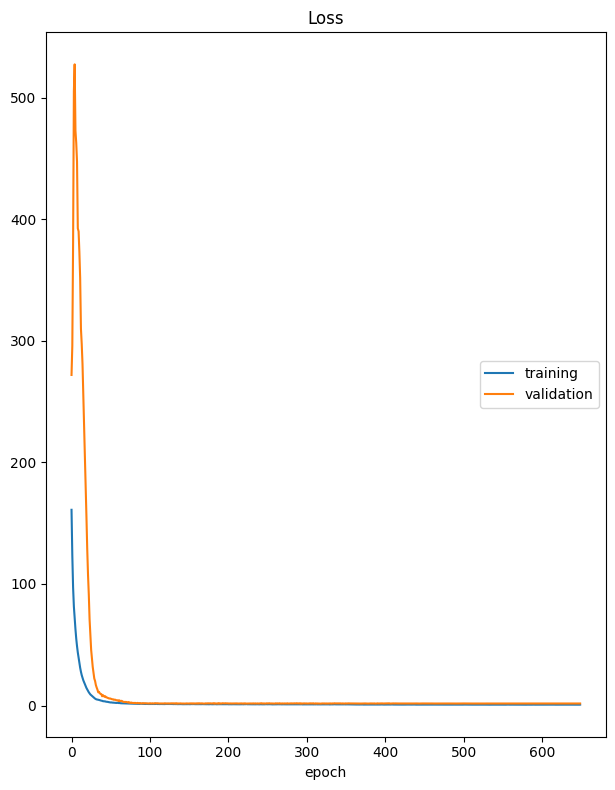

Loss
	training         	 (min:    0.719, max:  161.005, cur:    0.788)
	validation       	 (min:    1.541, max:  527.323, cur:    1.715)

Epoch 649: val_loss did not improve from 1.54103
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.7552 - val_loss: 1.7151 - learning_rate: 3.1250e-04
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
   nsamp  iter   MSE_Sub  MSE_Validation  MSE_Test  MSE_Training
0    100  1000  0.409983        1.719786  2.072109      1.807459


In [33]:
features = kiwi.loc[:,'X402':'X1065']
# Initialize lists to store results
results = []
enc_sizes = (16,)
#reg_sizes = (16,10,5,1)
kiwi_train = kiwi[kiwi['Dataset']=='Training']
unique_sample_ids_train =kiwi_train.sort_values('Date')['sample_id'].unique().tolist()

reg_sizes = [1]
# Define your nsamp values to iterate through
nsamp_values = [100,]
#nsamp_values = [50, 100, 250, 500,1000,8000]  # Adjust as needed
#nsamp_values = [200, 500, 1000,3000,8000]  # Adjust as needed

for nsamp in nsamp_values:
    unique_sample_ids = unique_sample_ids_train[-nsamp:]

    #dataset_enc = tf.data.Dataset.from_tensor_slices((features_x_norm.loc[repeated_kiwi_x['sample_id'].isin(unique_sample_ids),:].values, features_y_norm.loc[repeated_kiwi_y['sample_id'].isin(unique_sample_ids),:].values))
    #dataset_enc = dataset_enc.shuffle(buffer_size=len(features_x_norm.loc[repeated_kiwi_x['sample_id'].isin(unique_sample_ids),:]))
    dataset_enc = tf.data.Dataset.from_tensor_slices((features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:].values,features_y_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:].values))
    dataset_enc = dataset_enc.shuffle(buffer_size=len(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:]))
    dataset_enc = dataset_enc.batch(BATCH_SIZE)  # Batch the data
    dataset_label, repeats, features_sub_norm, target_sub = create_dataset_tail(nsamp=nsamp, kiwi=kiwi_sorted,target_column='DM')
    training_dataset = create_semi_supervised_dataset(dataset_enc, dataset_label,n_repeats=n_repeats).prefetch(tf.data.AUTOTUNE)

    barlow_model = BarlowRegressionModel(init_shape = (features_x_norm.shape[1],),loss_weight=(10.5,.5,0.5,0.),layer_sizes= enc_sizes, activation = "linear",barlow_lambda = 1/15,barlow_weight = 10.5,cov_weight = 1.0,activation_reg="linear",reg_sizes=reg_sizes,preprocess=3,conv1=1.,initializer = tf.keras.initializers.LecunNormal(seed=123))

    #barlow_model.compile(optimizer = tf.keras.optimizers.Lamb(learning_rate=0.01,clipvalue=1.))
    barlow_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005,clipvalue=1.))

    plot_losses = PlotLossesKerasTF()
    early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, mode='auto', restore_best_weights=True)
    #
    ### 2) Reduce learning rate dynamically
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)
    ### 3) Save the best weights into file
    checkpointer= keras.callbacks.ModelCheckpoint(filepath="model4a_weights.keras", verbose=1, save_best_only=True)

    history = barlow_model.fit(
        training_dataset,
        epochs=1000,
        validation_data=dataset_val,
        callbacks=[plot_losses,checkpointer,rdlr,early_stop]
    )
    # Make predictions
    preds_reg_val = barlow_model.predict(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Validation',:].values)[:,0]
    y_true_val = repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] == 'Validation','DM'].values

    preds_reg_test = barlow_model.predict(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Test',:].values)[:,0]
    y_true_test = repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] == 'Test','DM'].values

    preds_reg_sub = barlow_model.predict(features_sub_norm.values)[:,0]
    preds_reg_train = barlow_model.predict(features_x_norm.loc[repeated_kiwi_x['Dataset'] == 'Training',:].values)[:,0]
    y_true_train = repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] == 'Training','DM'].values

    # Calculate MSEs
    mse_val = np.mean((preds_reg_val - y_true_val)**2)
    mse_test = np.mean((preds_reg_test - y_true_test)**2)
    mse_train = np.mean((preds_reg_train - y_true_train)**2)
    mse_sub = np.mean((preds_reg_sub - target_sub)**2)
    # Store results
    results.append({
        'nsamp': nsamp,
        'iter' : 1000,
        'MSE_Sub': mse_sub,
        'MSE_Validation': mse_val,
        'MSE_Test': mse_test,
        'MSE_Training': mse_train
    })



# Create DataFrame
mse_results_df = pd.DataFrame(results)

# Display the results
print(mse_results_df)

# Optional: Save to CSV
#mse_results_df.to_csv('/content/drive/MyDrive/barlow_models_redoneJuly2025/mse_results_DM_small_enc_data_train_loss_sorted_train_norm_redone.csv', index=False)
features = kiwi.loc[:,'X402':'X1065']
features_norm=(features-features.loc[kiwi ['Dataset'] == 'Training',:].mean())/features.loc[kiwi ['Dataset'] == 'Training',:].std()


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


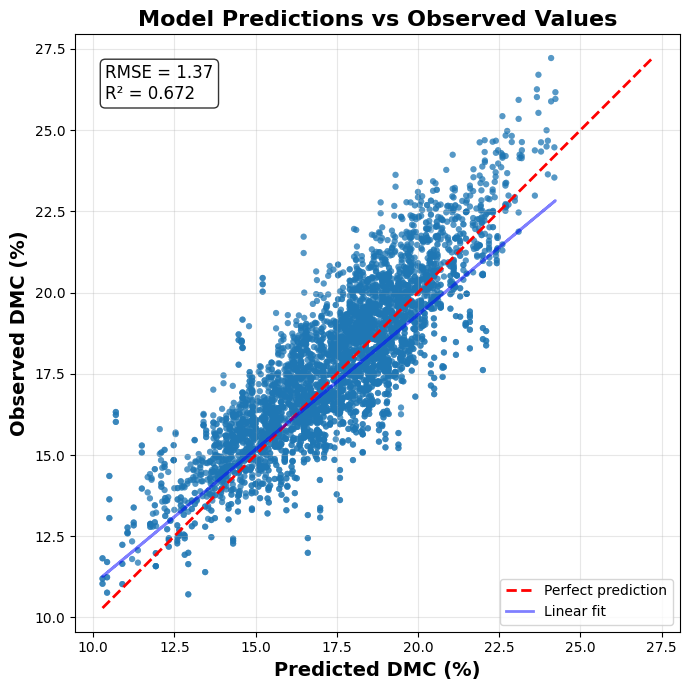

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


y_pred = barlow_model.predict(features_x_norm.loc[repeated_kiwi_x['Dataset'] != 'Training',:].values)[:,0]
y_true = repeated_kiwi_x.loc[repeated_kiwi_x['Dataset'] != 'Training','DM'].values
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot
plt.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='none')

# Perfect prediction line (y=x)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')

# Linear fit line
z = np.polyfit(y_pred, y_true, 1)
p = np.poly1d(z)
plt.plot(y_true, p(y_true), 'b-', alpha=0.5, linewidth=2, label='Linear fit')

# Add metrics text
textstr = f'RMSE = {rmse:.2f}\nR² = {r2:.3f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Labels and formatting
plt.ylabel('Observed DMC (%)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted DMC (%)', fontsize=14, fontweight='bold')
plt.title('Model Predictions vs Observed Values', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')  # 1:1 aspect ratio
plt.tight_layout()

# Save figure
plt.savefig('prediction_scatter.png', dpi=600, bbox_inches='tight')
plt.show()

Try without Barlow loss i.e. train on MSE only. Change the activation, initializer etc as needed.

In [38]:
init_shape = (features_x_norm.shape[1],)
inputs = keras.Input(shape=init_shape)
x = build_encoder(init_shape=init_shape, layer_sizes=enc_sizes, activation='linear', conv1=1.,initializer = tf.keras.initializers.glorot_uniform(seed=123),preprocess=3, num_layers=len(enc_sizes))(inputs)
x = get_regression_head(layer_sizes=enc_sizes, reg_sizes=reg_sizes , activation="linear")(x)
model = keras.Model(inputs, x)
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse')

(16,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
features_sub_norm

,X402,X405,X408,X411,X414,X417,X420,X423,X426,X429,...,X1038,X1041,X1044,X1047,X1050,X1053,X1056,X1059,X1062,X1065
8299,-0.546324,-0.883828,0.830094,0.468193,0.012558,-0.328210,-0.373610,-0.363521,-0.334118,-0.287477,...,-2.289954,-2.306246,-2.316281,-2.302937,-2.286800,-2.306430,-2.312731,-2.322457,-2.330637,-2.264328
8300,0.614112,0.032333,-0.429962,-0.901210,-1.590817,-2.128848,-2.579948,-2.683516,-2.575291,-2.445362,...,-2.264553,-2.239984,-2.245729,-2.257960,-2.267212,-2.272641,-2.255393,-2.266690,-2.277447,-2.273167
8302,1.507313,0.810533,0.401724,0.077043,-0.252543,-0.492988,-0.508577,-0.485295,-0.434268,-0.419677,...,0.207592,0.203382,0.217865,0.255630,0.250246,0.234519,0.254902,0.275315,0.319388,0.303000
8303,1.230265,0.888308,0.460833,0.160786,-0.070864,-0.118716,0.258293,0.645733,0.942259,1.203647,...,0.292414,0.291291,0.294042,0.349303,0.337227,0.315909,0.336892,0.333561,0.359956,0.312533
8301,1.705385,0.788856,0.362607,0.039997,-0.274609,-0.463175,-0.423059,-0.224746,-0.111085,-0.015978,...,0.982075,0.983612,0.987408,0.985317,1.011160,1.021321,1.049676,1.006473,0.965711,0.988601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8596,1.976062,0.963217,0.467412,0.137848,-0.159463,-0.380510,-0.376570,-0.345620,-0.321042,-0.330637,...,-0.686136,-0.689965,-0.709374,-0.720270,-0.729968,-0.748172,-0.764785,-0.764076,-0.765128,-0.814532
8595,-0.546324,0.750713,0.676820,0.267304,0.003194,-0.149700,-0.119586,0.036847,0.103910,0.172219,...,0.001994,-0.005348,0.013615,0.018337,0.011124,-0.003978,-0.013962,-0.030249,-0.052194,-0.069097
8598,-0.546324,-0.883828,0.858110,1.285788,0.605853,0.418188,0.421483,0.524459,0.467996,0.478237,...,-0.103169,-0.117906,-0.185511,-0.195912,-0.217039,-0.214066,-0.230970,-0.260669,-0.244937,-0.275672
8600,-0.546324,-0.883828,0.212906,1.140422,1.141083,1.133558,1.603390,2.005055,2.185960,2.233709,...,-0.539870,-0.557911,-0.555748,-0.641824,-0.653810,-0.641890,-0.698127,-0.699158,-0.688522,-0.723333


Compare to same model trained with MSE loss for the full training dataset

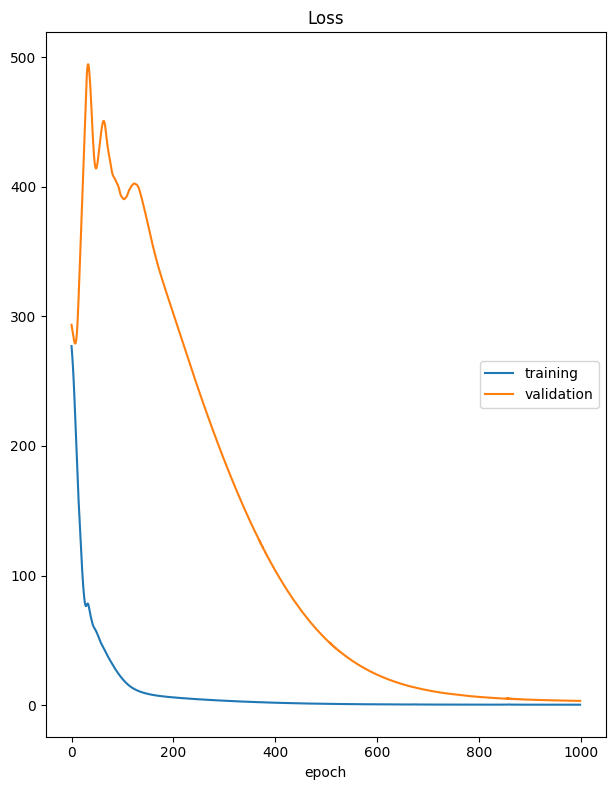

Loss
	training         	 (min:    0.388, max:  277.008, cur:    0.388)
	validation       	 (min:    3.322, max:  494.362, cur:    3.322)

Epoch 1000: val_loss improved from 3.32863 to 3.32210, saving model to model_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3878 - val_loss: 3.3221 - learning_rate: 0.0050


In [39]:
plot_losses = PlotLossesKerasTF()
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=150, mode='auto', restore_best_weights=True)
#
### 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)
### 3) Save the best weights into file
checkpointer= keras.callbacks.ModelCheckpoint(filepath="model_weights.keras", verbose=1, save_best_only=True)
history = model.fit(
    features_sub_norm, target_sub,
    epochs=1000,
    batch_size=500,
    validation_data=(features_norm.loc[kiwi['Dataset'] == 'Validation',:].values,kiwi.loc[kiwi['Dataset'] == 'Validation',"DM"].values),
    callbacks=[plot_losses,checkpointer,rdlr,early_stop]
)

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


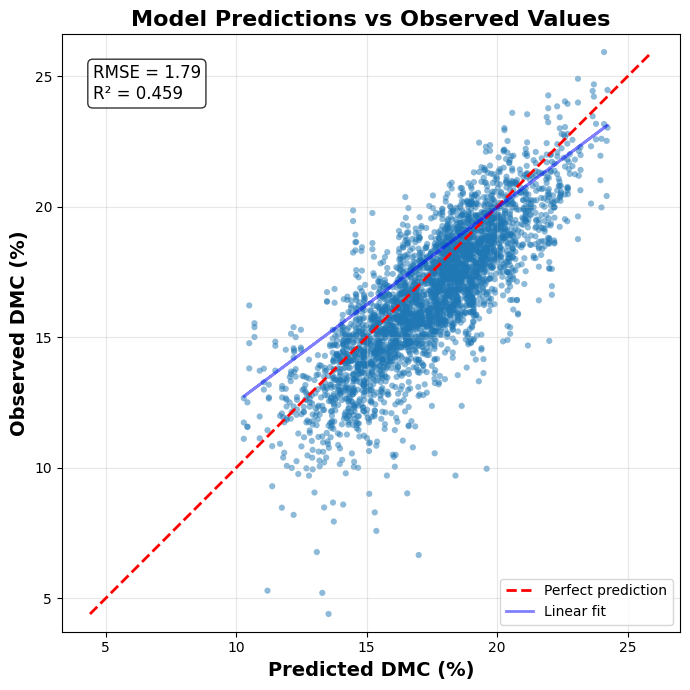

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


y_pred = model.predict(features_norm.loc[kiwi['Dataset'] != 'Training',:].values)[:,0]
y_true = kiwi.loc[kiwi['Dataset'] != 'Training','DM'].values
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot
plt.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='none')

# Perfect prediction line (y=x)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')

# Linear fit line
z = np.polyfit(y_pred, y_true, 1)
p = np.poly1d(z)
plt.plot(y_true, p(y_true), 'b-', alpha=0.5, linewidth=2, label='Linear fit')

# Add metrics text
textstr = f'RMSE = {rmse:.2f}\nR² = {r2:.3f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Labels and formatting
plt.ylabel('Observed DMC (%)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted DMC (%)', fontsize=14, fontweight='bold')
plt.title('Model Predictions vs Observed Values', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')  # 1:1 aspect ratio
plt.tight_layout()

# Save figure
plt.savefig('prediction_scatter.png', dpi=600, bbox_inches='tight')
plt.show()